# Group 14 - Project FP01
## Time series anomaly detection - LSTM-AD

This project aims at investigating the current state-of-the-arts TAD scenario.

In [ ]:
# !pip install pandas==1.5.3
# !pip install tsfel
# !pip install keras_tuner
# !pip install -U kaleido

In [1]:
import os
import time
import tsfel
import warnings
import datetime
import keras_tuner as kt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.cm as cm
from sklearn import metrics
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn import preprocessing
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import auc

from dataset import get_df_action, get_features_ts, get_train_test_data
from plots import seaborn_cm, create_and_plot_cm, plot_uncertainty, plot_signals, plot_anomalies, plot_anomalies_over_time, plot_roc_curve
from metrics import Confidence, anomaly_detection_metric, compute_metrics

#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

# Set style for matplotlib
plt.style.use("Solarize_Light2")

2024-07-21 20:05:49.847968: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-21 20:05:50.466463: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-21 20:05:50.466586: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-21 20:05:50.469107: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-21 20:05:50.678162: I tensorflow/core/platform/cpu_feature_g

In [2]:
# Path to the root directory of the dataset
ROOTDIR_DATASET_NORMAL =  '../../dataset/normal'#'/content/drive/MyDrive/Kuka_v1/normal'
ROOTDIR_DATASET_ANOMALY = '../../dataset/collisions'#'/content/drive/MyDrive/Kuka_v1/collisions'

# TF_ENABLE_ONEDNN_OPTS=0 means that the model will not use the oneDNN library for optimization

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

### Dataset: Kuka-v1
In 5 different recording sessions, the robot executes several different operations, while being
monitored by several sensors. The sensed signals are collected, with different sampling frequencies
(1, 10, 100, 200 Hz),

### Data Loading

In [3]:
#freq = '1.0'
freq = '0.1'
#freq = '0.01'
#freq = '0.005'

# NORMAL DATA
filepath_csv = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.csv") for r in [0, 2, 3, 4]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.metadata") for r in [0, 2, 3, 4]]
df_action, df, df_meta, action2int = get_df_action(filepath_csv, filepath_meta)


# COLLISION DATA
xls = pd.ExcelFile(os.path.join(ROOTDIR_DATASET_ANOMALY, "20220811_collisions_timestamp.xlsx"))
collision_rec1 = pd.read_excel(xls, 'rec1')
collision_rec5 = pd.read_excel(xls, 'rec5')

collisions = pd.concat([collision_rec1, collision_rec5])
collisions_init = collisions[collisions['Inizio/fine'] == "i"].Timestamp - pd.to_timedelta([2] * len(collisions[collisions['Inizio/fine'] == "i"].Timestamp), 'h')

filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.csv") for r in [1, 5]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.metadata") for r in [1, 5]]
df_action_collision, df_collision, df_meta_collision, action2int_collision = get_df_action(filepath_csv, filepath_meta)

filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec1_collision_20220811_rbtc_{freq}s.csv")]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec1_collision_20220811_rbtc_{freq}s.metadata")]
df_action_collision_1, df_collision_1, df_meta_collision_1, action2int_collision_1 = get_df_action(filepath_csv, filepath_meta)

filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec5_collision_20220811_rbtc_{freq}s.csv")]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec5_collision_20220811_rbtc_{freq}s.metadata")]
df_action_collision_5, df_collision_5, df_meta_collision_5, action2int_collision_5 = get_df_action(filepath_csv, filepath_meta)

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.



### Features Exctraction

In [7]:
start_time = time.time()
frequency = 1/float(freq)
df_features = get_features_ts("statistical", df_action, df_meta, frequency, action2int)
df_features_collision = get_features_ts("statistical", df_action_collision, df_meta_collision, frequency, action2int_collision)
df_features_collision_1 = get_features_ts("statistical", df_action_collision_1, df_meta_collision_1, frequency, action2int_collision_1)
df_features_collision_5 = get_features_ts("statistical", df_action_collision_5, df_meta_collision_5, frequency, action2int_collision_5)
print("--- %s seconds ---" % (time.time() - start_time))

Computing features.


Skipped feature extraction for pickFromPallet(1,2)=[true,1,0] 2022-08-11 14:37:37.436000 : 2022-08-11 14:37:37.421000.
Skipped feature extraction for placeToPallet(1,1)=[true,0] 2022-08-11 14:37:37.421000 : 2022-08-11 14:37:37.442000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.568000 : 2022-08-11 15:36:32.533000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.572000 : 2022-08-11 15:36:32.561000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.533000 : 2022-08-11 15:36:32.572000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.561000 : 2022-08-11 15:36:32.561000.
Computing features done.
Computing features.


Skipped feature extraction for moveOverPallet(1,3)=[true,0] 2022-08-11 16:55:15.149000 : 2022-08-11 16:55:15.146000.
Skipped feature extraction for moveOverPallet(3,1)=[true,0] 2022-08-11 16:55:15.146000 : 2022-08-11 16:55:15.150000.
Computing features done.
Computing features.


Computing features done.
Computing features.


Skipped feature extraction for moveOverPallet(1,3)=[true,0] 2022-08-11 16:55:15.149000 : 2022-08-11 16:55:15.146000.
Skipped feature extraction for moveOverPallet(3,1)=[true,0] 2022-08-11 16:55:15.146000 : 2022-08-11 16:55:15.150000.
Computing features done.
--- 120.81547451019287 seconds ---


In [8]:
X_train, y_train, X_test, y_test = get_train_test_data(df_features, df_features_collision)
X_train1, y_train1, X_test1, y_test1 = get_train_test_data(df_features, df_features_collision_1, full_normal=True)
X_train5, y_train5, X_test5, y_test5 = get_train_test_data(df_features, df_features_collision_5, full_normal=True)

X_train shape: (973, 2200)
y_train shape: (973,)
X_test shape: (306, 2200)
y_test shape: (306,)
X_train shape: (973, 96)
y_train categorical shape: (973, 31)
y_train shape: (973,)
X_test shape: (306, 96)
y_test shape: (306,)
X_train shape: (973, 2200)
y_train shape: (973,)
X_test shape: (164, 2200)
y_test shape: (164,)
X_train shape: (973, 96)
y_train categorical shape: (973, 31)
y_train shape: (973,)
X_test shape: (164, 96)
y_test shape: (164,)
X_train shape: (973, 2200)
y_train shape: (973,)
X_test shape: (141, 2200)
y_test shape: (141,)
X_train shape: (973, 96)
y_train categorical shape: (973, 31)
y_train shape: (973,)
X_test shape: (141, 96)
y_test shape: (141,)



## LSTM-AD

In [9]:
from algorithms.lstm_ad import LSTMAD

def prepare_data_for_lstm(data, len_in):
    """
    Prepare data for LSTM-AD by concatenating every len_in rows.
    """
    n_features = data.shape[1]
    n_samples = data.shape[0] // len_in
    prepared_data = data.iloc[:n_samples * len_in].values.reshape(n_samples, -1)
    return pd.DataFrame(prepared_data, index=data.index[len_in-1:len_in*n_samples:len_in])

# CURRENTLY FUCKS UP FOR VALUES OF LEN_IN AND LEN_OUT DIFFERENT FROM 1
len_in = 1
X_train_lstm = prepare_data_for_lstm(X_train, len_in)
print(X_train_lstm.shape)

classifier = LSTMAD(
    len_in=len_in,         # Input sequence length
    len_out=1,             # Output sequence length (prediction horizon)
    num_epochs=100,         # Number of training epochs
    lr=1e-3,               # Learning rate
    batch_size=1,          # Batch size (usually 1 for time series)
    seed=42,               # Random seed for reproducibility
    gpu=None,              # Set to None for CPU, or specify GPU index if available
    details=True           # Set to True to get detailed predictions
)

# Train the LSTM on normal data
classifier.fit(X_train_lstm)
print("LSTM-AD training completed.")


(973, 96)


100%|██████████| 100/100 [00:21<00:00,  4.61it/s]

LSTM-AD training completed.


### Anomaly Detection

Anomaly prediction completed.


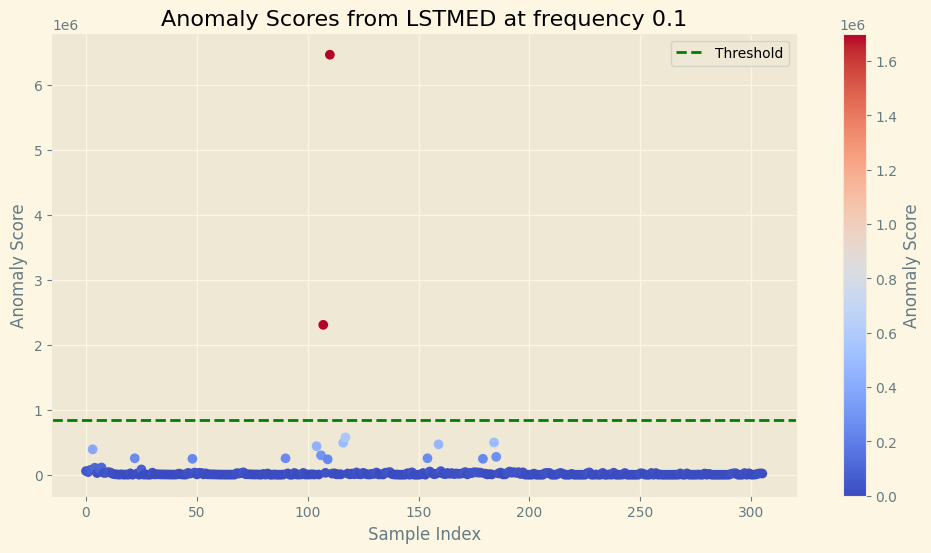

Number of anomalies detected: 2
Anomaly prediction completed.


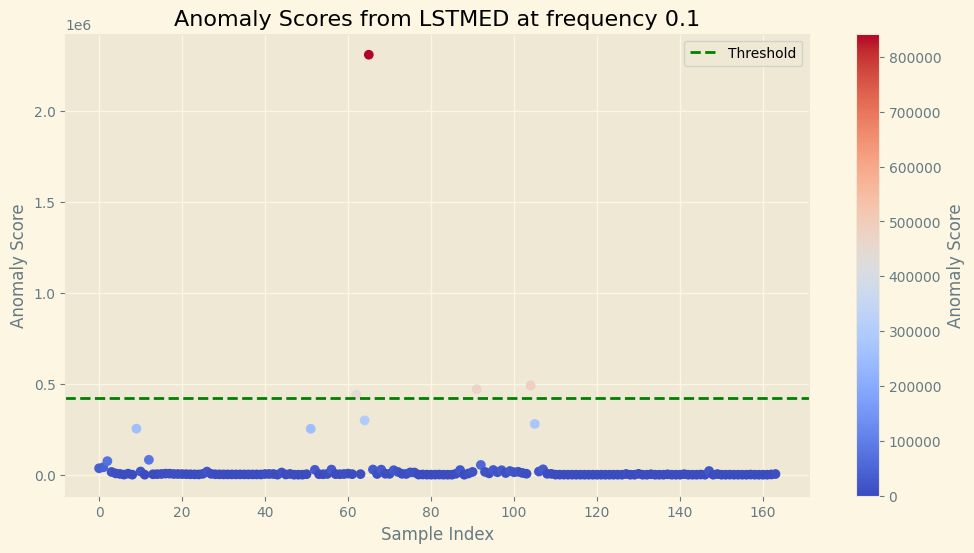

Number of anomalies detected: 4
Anomaly prediction completed.


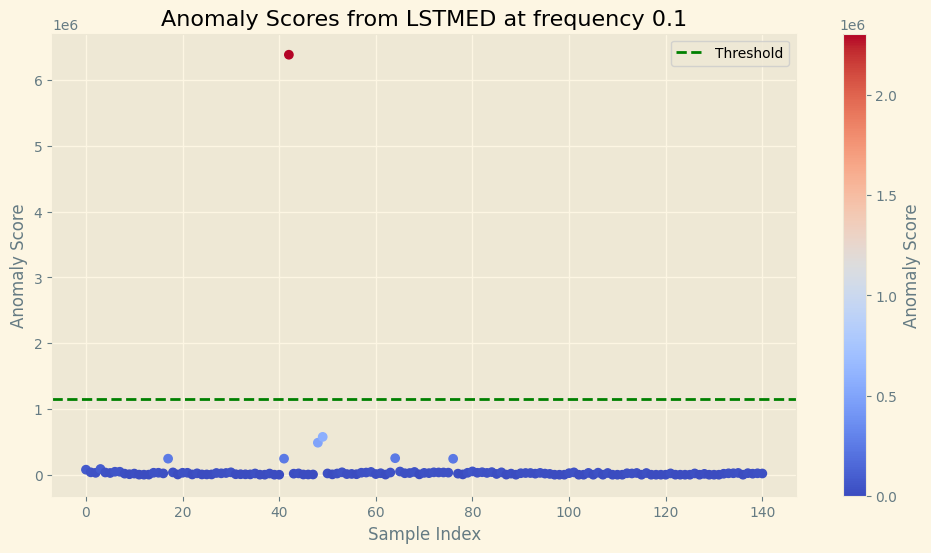

Number of anomalies detected: 1


In [10]:
anomaly_scores, anomalies_detected = plot_anomalies(classifier, X_test, y_test, freq)
anomaly_scores1, anomalies_detected1 = plot_anomalies(classifier, X_test1, y_test1, freq)
anomaly_scores5, anomalies_detected5 = plot_anomalies(classifier, X_test5, y_test5, freq)

In [11]:
anomaly_scores, y_test_binary = compute_metrics(classifier, X_test, y_test)
anomaly_scores1, y_test_binary1 = compute_metrics(classifier, X_test1, y_test1)
anomaly_scores5, y_test_binary5 = compute_metrics(classifier, X_test5, y_test5)

Anomaly scores statistics:
Mean: 56316.370408673596
Std: 397001.6500591943
Min: -4.888561813833498
Max: 6467558.95891892
ROC AUC Score: 0.6839
Detected anomaly class: 7
Threshold: 850319.6705
F1 Score: 0.1379
Accuracy: 0.9183
Precision: 1.0000
Recall: 0.0741
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       279
           1       1.00      0.07      0.14        27

    accuracy                           0.92       306
   macro avg       0.96      0.54      0.55       306
weighted avg       0.93      0.92      0.88       306

Anomaly scores statistics:
Mean: 35461.791352362874
Std: 192842.7194298776
Min: 1.4530271216570156
Max: 2307787.82543303
ROC AUC Score: 0.7445
Detected anomaly class: 7
Threshold: 421147.2302
F1 Score: 0.2105
Accuracy: 0.9085
Precision: 0.5000
Recall: 0.1333
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       149
           1       0.50      0.13      0.21   

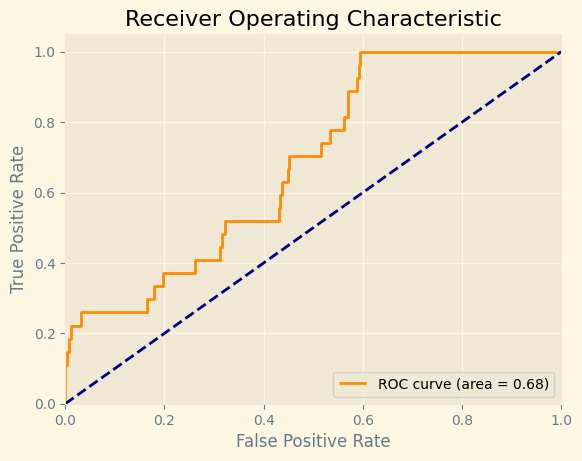

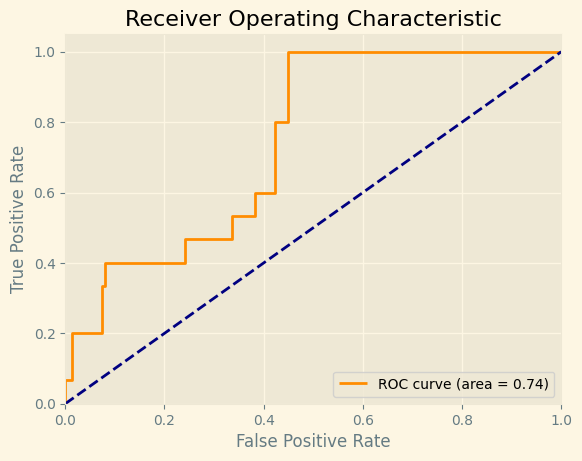

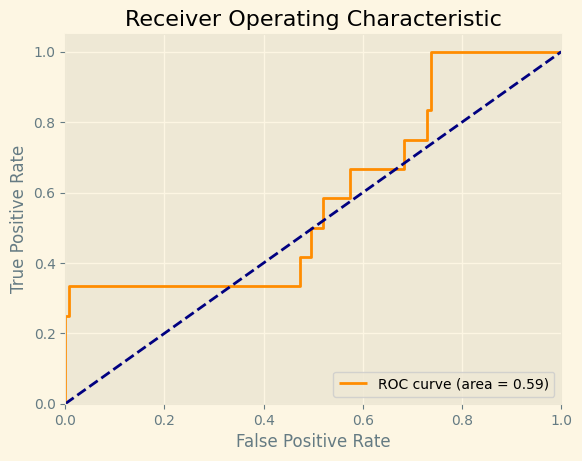

In [12]:
plot_roc_curve(y_test_binary, anomaly_scores)
plot_roc_curve(y_test_binary1, anomaly_scores1)
plot_roc_curve(y_test_binary5, anomaly_scores5)

## Map anomalies to original time series

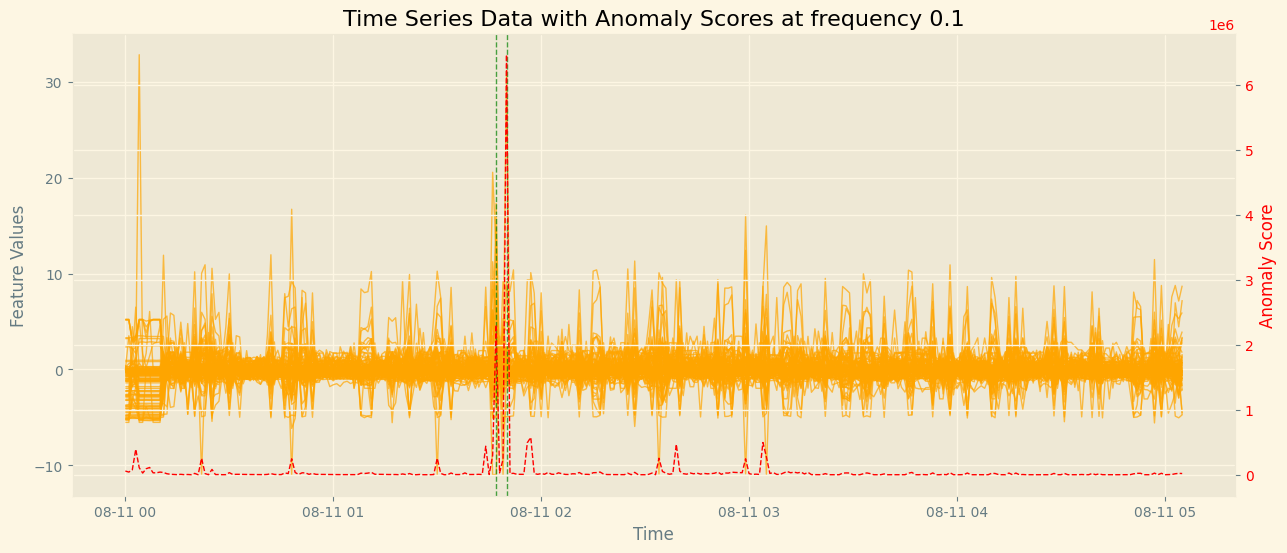

Top 2 Anomalies:
              timestamp  anomaly_score  \
110 2022-08-11 01:50:00   6.467559e+06   
107 2022-08-11 01:47:00   2.308015e+06   

     machine_nameKuka Robot_apparent_power-_Average power  \
110                                          -0.911260      
107                                          -1.181816      

     machine_nameKuka Robot_apparent_power-_Variance  \
110                                         0.246879   
107                                        -0.009713   

     machine_nameKuka Robot_current-_Min  \
110                             0.235311   
107                            -0.911095   

     machine_nameKuka Robot_phase_angle-_Average power  \
110                                          -1.270309   
107                                          -1.563128   

     machine_nameKuka Robot_phase_angle-_Variance  \
110                                      4.879634   
107                                      6.563108   

     machine_nameKuka Robot_power-_

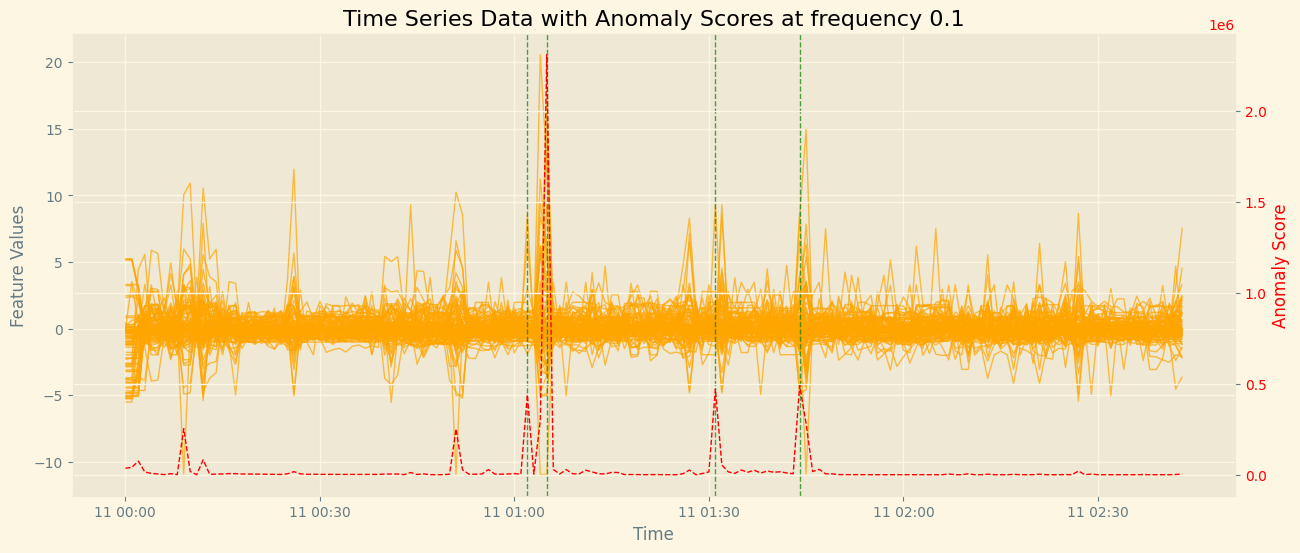

Top 4 Anomalies:
              timestamp  anomaly_score  \
65  2022-08-11 01:05:00   2.307788e+06   
104 2022-08-11 01:44:00   4.901179e+05   
91  2022-08-11 01:31:00   4.704691e+05   
62  2022-08-11 01:02:00   4.392874e+05   

     machine_nameKuka Robot_apparent_power-_Average power  \
65                                           -1.181816      
104                                          -1.514041      
91                                           -0.082477      
62                                            0.687388      

     machine_nameKuka Robot_apparent_power-_Variance  \
65                                         -0.009713   
104                                         0.871440   
91                                         -0.093518   
62                                          0.418795   

     machine_nameKuka Robot_current-_Min  \
65                             -0.911095   
104                             0.212076   
91                             -0.950498   
62       

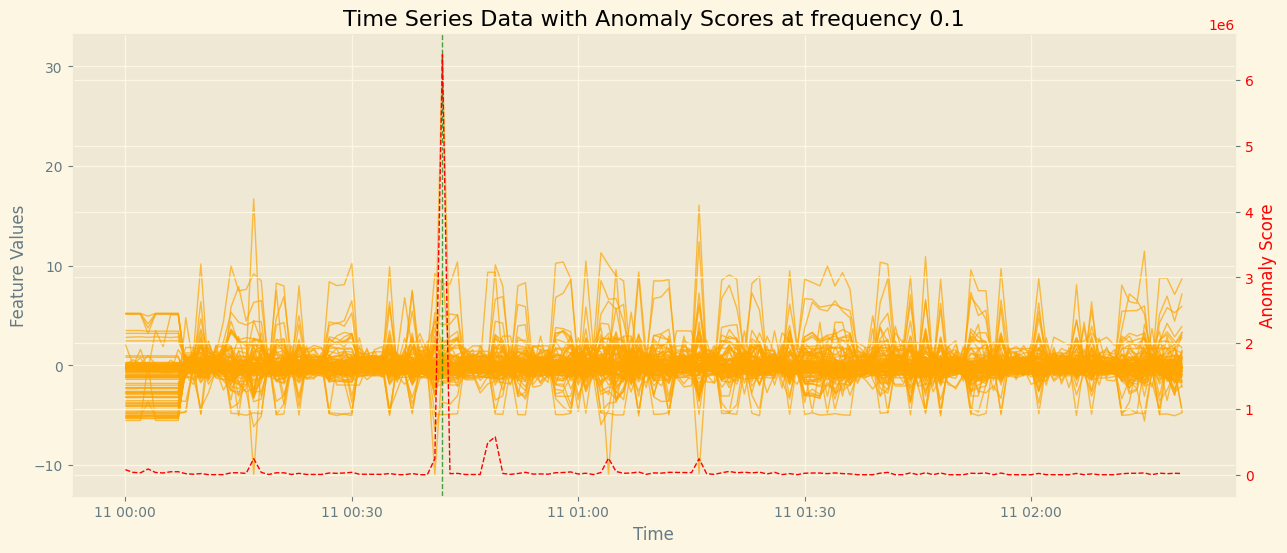

Top 1 Anomalies:
             timestamp  anomaly_score  \
42 2022-08-11 00:42:00   6.387438e+06   

    machine_nameKuka Robot_apparent_power-_Average power  \
42                                           -0.91126      

    machine_nameKuka Robot_apparent_power-_Variance  \
42                                         0.246879   

    machine_nameKuka Robot_current-_Min  \
42                             0.235311   

    machine_nameKuka Robot_phase_angle-_Average power  \
42                                          -1.270309   

    machine_nameKuka Robot_phase_angle-_Variance  \
42                                      4.879634   

    machine_nameKuka Robot_power-_ECDF Percentile_0  \
42                                         0.051439   

    machine_nameKuka Robot_power-_Min  \
42                          -4.930048   

    machine_nameKuka Robot_power_factor-_Histogram_9  ...  \
42                                           0.52563  ...   

    sensor_id5_AngX-_Median absolute deviati

In [13]:
plot_anomalies_over_time(X_test, anomaly_scores, anomalies_detected, freq)
plot_anomalies_over_time(X_test1, anomaly_scores1, anomalies_detected1, freq)
plot_anomalies_over_time(X_test5, anomaly_scores5, anomalies_detected5, freq)